# PyNeuraLogic Introduction Example

---

This example will showcase how to define a model in the PyNeuraLogic language and evaluate it. The example is self-contained - contains everything that is required to be run in colab. It can also be run locally if all prerequisites are met (installed Java).

Install PyNeuraLogic from PyPI

In [ ]:
! pip install neuralogic

## Dataset

We are going to use one of the predefined datasets called [Mutagenesis](https://www.doc.ic.ac.uk/~shm/mutagenesis.html). This dataset contains information about molecules that we are going to classify for mutagenicity on Salmonella typhimurium.

Predefined datasets are located in `neuralogic.utils.data`, and by calling `Mutagenesis`, we retrieve a tuple containing the template and the input data (dataset). For this example, we are going to ignore the template and will define our own.

In [1]:
from neuralogic.utils.data import Mutagenesis


_, dataset = Mutagenesis()

Predefined examples are loaded from the file. We can check the first sample to get an idea how the data look like.

In [2]:
! head -n1 /usr/local/lib/python3.7/dist-packages/neuralogic/utils/data/datasets/molecules/mutagenesis/examples.txt

bond(d59_23, d59_5, 0), h_3(d59_23), c_22(d59_5), b_1(0), bond(d59_5, d59_23, 0), bond(d59_20, d59_19, 1), c_21(d59_20), c_21(d59_19), b_7(1), bond(d59_19, d59_20, 1), bond(d59_10, d59_3, 2), c_27(d59_10), c_27(d59_3), b_7(2), bond(d59_3, d59_10, 2), bond(d59_14, d59_10, 3), c_25(d59_14), b_7(3), bond(d59_10, d59_14, 3), bond(d59_4, d59_3, 4), c_22(d59_4), b_7(4), bond(d59_3, d59_4, 4), bond(d59_10, d59_9, 5), c_27(d59_9), b_7(5), bond(d59_9, d59_10, 5), bond(d59_15, d59_28, 6), c_22(d59_15), h_3(d59_28), b_1(6), bond(d59_28, d59_15, 6), bond(d59_12, d59_13, 7), c_27(d59_12), c_27(d59_13), b_7(7), bond(d59_13, d59_12, 7), bond(d59_8, d59_9, 8), c_22(d59_8), b_7(8), bond(d59_9, d59_8, 8), bond(d59_7, d59_25, 9), c_22(d59_7), h_3(d59_25), b_1(9), bond(d59_25, d59_7, 9), bond(d59_30, d59_17, 10), h_3(d59_30), c_22(d59_17), b_1(10), bond(d59_17, d59_30, 10), bond(d59_15, d59_12, 11), b_7(11), bond(d59_12, d59_15, 11), bond(d59_2, d59_1, 12), c_27(d59_2), c_22(d59_1), b_7(12), bond(d59_1, d

This format is slightly different from the PyNeuraLogic language. Such sample would be represented in PyNeuraLogic as:

```
Relation.bond(Term.d59_23, Term.d59_5, 0), Relation.h_3(Term.d59_23), ...
```

We are essentially encoding heterogeneous graphs with edges called `bonds`, where the first two terms are atoms identifications, and the third term is the relation identification. Atoms ids are then associated with specific atoms (types), such as `h_3` (hydrogen with id 3). Bonds ids are associated with bond types such as `b_1` etc.

## Template

To define the template (model's 'architecture'), we first embed each atom to `atom_embed` with unique learnable parameters of shape `[3, 1]`. This can be simplified by utilizing list comprehension.

In [3]:
from neuralogic.core import Template, Settings, R, V


template = Template()

atom_names = [
    "c_26", "c_27", "c_25", "c_28", "c_29", "o_49", "br_94", "o_40", "o_41", "o_42", "o_45", "i_95",
    "f_92", "h_1", "h_3", "c_10", "c_14", "c_194", "c_195", "c_16", "h_8", "c_19", "c_230", "c_232",
    "o_50", "n_36", "o_52", "n_35", "n_34", "o_51", "n_32", "n_31", "cl_93", "c_21", "c_22", "n_38",
]

template.add_rules([
    (R.atom_embed(V.A)[3, 1] <= R.get(atom)(V.A)) for atom in atom_names
])

In the same way, we encode embeddings for bonds.

In [4]:
template.add_rules([
    (R.bond_embed(V.B)[3, 1] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

We add one rule (layer), which follows the message passing framework. It aggregates all neighbors `Y` (nodes connected by bond relation) of the central node `X` and projects representations of `X` and `Y` from the previous layer (`atom_embed`) through learnable parameters of shape `[3, 3]`.  We then combine those projections together with bond embedding. We get a list of values for each neighbor `Y`, which are again combined into one tensor to serve as the output of the relation `layer_1` for node `X`.

In [5]:
template.add_rule(
    R.layer_1(V.X) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
)

In the same way, we add another two layers that are connected by utilizing representations from the previous layer. 

In [6]:
template.add_rules([
    R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
    R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
])

In the last layer, we aggregate all nodes' (atoms') representations from the previous layer (`layer_3`), combine them, and project them through the learnable parameter of shape `[1, 3]` into a scalar value. This layer is our target output layer (specified by queries).

In [7]:
template.add_rule(
    R.predict[1, 3] <= R.layer_3(V.X),
)

## Training

When we have our dataset and template ready, it's time to build and train the model. We can do the training manually and write our own custom training loop, but we can also use predefined helpers - evaluators, that handle model building, training, dataset building, and more. Evaluators can be customized via `Settings`.

In [8]:
from neuralogic.core import Backend, Settings, Optimizer, ErrorFunction
from neuralogic.nn import get_evaluator


epochs = 120

settings = Settings(optimizer=Optimizer.ADAM, epochs=epochs, learning_rate=0.001, error_function=ErrorFunction.SQUARED_DIFF)
evaluator = get_evaluator(template, Backend.JAVA, settings)

We iterate over the iterator encapsulated in the `train` method for training, which yields a total loss of the epoch and the number of samples of the current epoch. We then get access to results from the training loop that we can further visualize, inspect, log, etc.

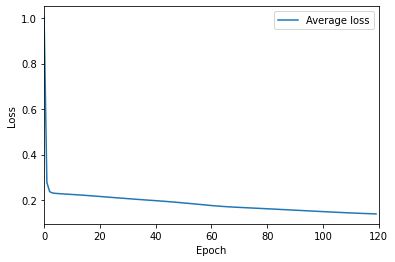

In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


average_losses = []

for current_total_loss, number_of_samples in evaluator.train(dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

We can also check what values are the model outputs for our training set by utilizing the `test` method.

In [10]:
for y, y_hat in evaluator.test(dataset):
    print(f"Expected: {y}, Predicted: {round(y_hat)} ({y_hat})")

Expected: 1.0, Predicted: 1 (0.8525149348120282)
Expected: 1.0, Predicted: 1 (0.8406984722243998)
Expected: 1.0, Predicted: 1 (0.5513105191358397)
Expected: 1.0, Predicted: 1 (0.659408747421369)
Expected: 1.0, Predicted: 0 (0.15425569739005504)
Expected: 1.0, Predicted: 1 (0.7255243020373396)
Expected: 1.0, Predicted: 1 (0.7251277795783413)
Expected: 1.0, Predicted: 1 (0.6238415741463218)
Expected: 1.0, Predicted: 1 (0.76204175397132)
Expected: 1.0, Predicted: 1 (0.594847240341925)
Expected: 1.0, Predicted: 1 (0.6176828308931789)
Expected: 1.0, Predicted: 1 (0.6661693199510752)
Expected: 1.0, Predicted: 0 (0.48132840572743013)
Expected: 1.0, Predicted: 0 (0.4892026371525004)
Expected: 1.0, Predicted: 1 (0.7076789130574961)
Expected: 1.0, Predicted: 0 (0.4612140223363981)
Expected: 1.0, Predicted: 1 (0.7609292703378965)
Expected: 1.0, Predicted: 1 (0.7522559757310268)
Expected: 1.0, Predicted: 1 (0.6752308969243719)
Expected: 1.0, Predicted: 1 (0.793958006608344)
Expected: 1.0, Predicte